# Plan and Execute

## Setup

In [1]:
from dotenv import load_dotenv, find_dotenv
import os

In [2]:
load_dotenv(find_dotenv())
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["AGENTOPS_API_KEY"] = os.getenv("AGENTOPS_API_KEY")

In [3]:
from agentops.langchain_callback_handler import (
    LangchainCallbackHandler as AgentOpsLangchainCallbackHandler,
)
import agentops

agentops.init(os.environ["AGENTOPS_API_KEY"])
agentops_handler = AgentOpsLangchainCallbackHandler(
    api_key=os.environ["AGENTOPS_API_KEY"], tags=["Plan and Execute"]
)

🖇 AgentOps: Session Replay: https://app.agentops.ai/drilldown?session_id=c67902fb-10d6-41c9-a2dc-28776d7df80d


## Defining Tools

We will first define the tools we want to use. For this example, we will use a powerfull search tool exa

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]
for t in tools:
    t.callbacks = [agentops_handler]

## Define our Execution Agent

In [48]:
from langchain import hub
from langchain_groq import ChatGroq
# from langgraph.prebuilt import create_react_agent
from langchain.agents import AgentExecutor, create_react_agent

prompt = hub.pull("hwchase17/react")
prompt.pretty_print()

llm = ChatGroq(callbacks=[agentops_handler])

agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, handle_parsing_errors=True)

Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}


In [49]:
agent_executor.invoke({"input": "Who won the recent EURO CUP and COPA America final?"})

{'input': 'Who won the recent EURO CUP and COPA America final?',
 'output': 'Italy won the recent EURO CUP and Argentina won the recent COPA America final.'}

## Define the State

Defining the state the track for this agent.

First, we will need to track the current plan. Let's represent that as a list of strings.

Nest we should track previously executed steps. Let's represent that as a list of tuples(these tuples will contain the step result)

Finally, we need to have some state to represent the final response as well as the original input.

In [50]:
import operator
from typing import Annotated, List, Tuple, TypedDict

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response:str

## Planning Step
Creating the planning step. This will use function calling to create a plan.

In [51]:
from langchain_core.pydantic_v1 import BaseModel, Field

class Plan(BaseModel):
    """Plan to follow in future"""
    
    steps: List[str] = Field(
        ...,
        description = "Steps to follow, in order"
    )

In [52]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objetive, come up with a simple step by step plan.
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps.
The result of the final step should be the final answer. Make sure that each step has all the information needed - donot skip steps.
Output your response in the following JSON format: "steps": ["Step 1","Step 2","Step 3"]
""",
        ),
        ("placeholder", "{messages}"),
    ]
)

planner = planner_prompt | ChatGroq(callbacks=[agentops_handler]).with_structured_output(Plan)

In [53]:
planner.invoke(
    {
        "messages": [
            ("user", "Who is the key player of the team winning the recent Euro Cup final?")            
        ]
    }
)

Plan(steps=['Identify the team that won the recent Euro Cup final', 'Find out the key players of the identified team'])

## Replan Step
Now, lets create a step that re-does the plan based on the result of previous steps

In [54]:
from typing import Union

class Response(BaseModel):
    """Response to user."""
    
    response: str
    
class Act(BaseModel):
    """Action to perform."""
    
    action: Union[Response, Plan] = Field(
        description = "Action to perform. If you find the answer or want to respond to user, use Response."
        "If you need to further use tools to get the answer, use Plan."
    )
    
replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan.
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Donot add any super flous steps.
The result of the final step should be the final answer. Make sure that each step has all the information needed - donot skip steps.

Your objective was like this:
{input}

Your original plan was this:
{plan}

You have currently done the following steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the use, then respond with that.
Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Donot return previously done steps as part of the plan."""
)

replanner = replanner_prompt | ChatGroq(callbacks=[agentops_handler]).with_structured_output(Act)

## Create the Graph

In [63]:
from typing import Literal

async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    
    task_formatted = f"""For the following plan: {plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"input": [("user", task_formatted)]}
    )
    
    if isinstance(agent_response, dict):
        if "response" in agent_response:
            content = agent_response["response"]
        elif "output" in agent_response:
            content = agent_response["output"]
        else:
            content = str(agent_response)  # Fallback to string representation
    else:
        content = str(agent_response)
    
    return {
        "past_steps": [(task, content)]
    }
    

async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}
    # except BadRequestError as e:
    #     # If there's an error, try to extract the response from the error message
    #     error_data = e.response.json()
    #     failed_generation = error_data['error'].get('failed_generation', '')
    #     if 'response' in failed_generation:
    #         import json
    #         try:
    #             response_data = json.loads(failed_generation.replace('<tool-use>\n', '').replace('</tool-use>', ''))
    #             return {"response": response_data['tool_call']['parameters']['action']['response']['response']}
    #         except json.JSONDecodeError:
    #             pass
    #     # If we can't extract a response, raise the error
    #     raise
    

def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"
    

SyntaxError: expected 'except' or 'finally' block (3820109515.py, line 55)

In [64]:
from langgraph.graph import StateGraph

workflow = StateGraph(PlanExecute)

# Add the plan to the node
workflow.add_node("planner", plan_step)

# Add the plan to execution step
workflow.add_node("agent", execute_step)

# Add the replan node
workflow.add_node("replan", replan_step)

workflow.set_entry_point("planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will dettermine which node is called next.
    should_end,
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would ant other runnable
app = workflow.compile()

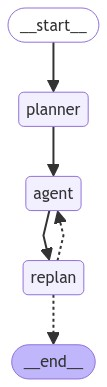

In [65]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [66]:
config = {"recursion_limit": 50}
inputs = {"input": "Who is the current prime minister of Pakistan?"}

async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__": 
            print(v)
        else:
            print(k)

{'plan': ['Identify the current year', 'Find out the name of the political party in power in Pakistan during the identified year', 'Identify the leader of the identified political party', 'Confirm if the identified person is the current Prime Minister of Pakistan']}
{'past_steps': [('Identify the current year', 'The current year is 2022.')]}


🖇 AgentOps: Error: maximum recursion depth exceeded


NameError: name 'BadRequestError' is not defined

In [19]:
config = {"recursion_limit": 50}
inputs = {"input": "Who is the key player of the team winning the recent Euro Cup final?"}

async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__": 
            print(v)

{'plan': ['Identify the team that won the recent Euro Cup final', 'Find out the key players of the identified team']}
{'past_steps': [('Identify the team that won the recent Euro Cup final', 'The winner of the recent Euro Cup final is Spain.')]}
{'plan': ['Find out the key players of the Spanish national football team']}
{'past_steps': [('Find out the key players of the Spanish national football team', 'The key players of the Spanish national football team include Lamine Yamal, Alvaro Morata, Nico Williams, Martin Zubimendi, Pedri, and Mikel Oyarzabal.')]}
{'plan': ['Identify the key player of the Spanish national football team in the recent Euro Cup final']}
{'past_steps': [('Identify the key player of the Spanish national football team in the recent Euro Cup final', "The key player of the Spanish national football team in the recent Euro Cup final is Rodri, who was named the best player of Euro 2024 and made significant contributions to the team's performance throughout the tournamen